<a href="https://colab.research.google.com/github/AlePa98/DeepInversion/blob/master/DeepInversion_prova_Alessandro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install 'import_ipynb'
!pip3 install 'tqdm'
 
!rm -r IncrementalLearning
# upload work files from your git hub repository
import sys
 
!git clone https://github.com/alessandronicolini/IncrementalLearning.git # clone proj repository
!rm -rf IncrementalLearning/README.md 
!rm -rf IncrementalLearning/baselines.ipynb
 
path = 'IncrementalLearning/'
if path not in sys.path:
    sys.path.append('IncrementalLearning/')
 
!pip3 install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=3f957495c759d07f9d5d8a8ca8c17f4f5408aa655744dee3c62f9bca2f72665d
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
rm: cannot remove 'IncrementalLearning': No such file or directory
Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 640 (delta 102), reused 0 (delta 0), pack-reused 474
Receiving objects: 100% (640/640), 860.31 KiB | 8.35 MiB/s, done.
Resolving deltas: 100% (377/377), done.


In [115]:
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import VisionDataset
from PIL import Image
import random
import torchvision
ROOT = './data'
class ilCIFAR100(VisionDataset):
    """
    Extends CIFAR100 class. Split the dataset into 10 batches, each one containing 10 classes.
    You can retrieve the batches from the attribute "batches", it has different structure according to
    test and train CIFAR100 splits:
        - train -> batches is a dictionary {0:{'train':indexes, 'val':indexes}...} 
        - test -> batches is a dictionary {0:indexes...}
    where the keys are the batch number.

    Args:
        root (string): Root directory of dataset where directory
            `cifar-10-batches-py` exists or will be saved to if download is set to True.
        seed(int): used to ensure reproducibility in shuffling operations.
        val_size(float, optional): between 0 and 1, fraction of data used for validation.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, `transforms.RandomCrop`
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    def __init__(self,classes_per_batch, seed, val_size=0.1, train=True, transform=None, target_transform=False, 
    download=True):
        
        super(ilCIFAR100, self).__init__(root=0)
        self.classes_per_batch=classes_per_batch

        
        self.__rs = seed # set random seed 
        self.train=train
        self.__transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

        self.__transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])
        # if train:
        #     self.batches = self.__make_train_batches(val_size)
        # else:
        #     self.batches = self.__make_test_batches()
        if self.train == 'train':
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=True,
                                            download=True, transform=self.__transform_train)
        elif self.train == 'exemplars':
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=True,
                                            download=True, transform=self.__transform_test)
        else:
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=False,
                                        download=True, transform=self.__transform_test)
          
        self.targets = np.array(self.dataset.targets) # make targets an array to exploit masking
        random.seed(seed)
        self.classes = random.sample(range(0, 100), 100)
        #self.classes = self.classes.reshape((10, -1)) # each row contains the classes for the corrisponding batch
        #print(self.classes)
        self.__dictionary = {}
        for i, c in enumerate(self.classes):
          self.__dictionary[c] = i


    def get_dict(self):
      return self.__dictionary
    def __getitem__(self, index):
        return index,self.dataset.__getitem__(index)[0],self.dataset.__getitem__(index)[1]
    def __len__(self):
        return self.dataset.__len__()
    def getbatches(self):
      classlist=self.classes
      batches=[]
      for i in range(0,int(100/self.classes_per_batch)):
        #print(i)
        batch=classlist[int(i*self.classes_per_batch):int(i*10+self.classes_per_batch)]
        batches.append(batch)
      return batches
    def get_batch_indexes(self):
      classlist=self.classes
      numclass=self.classes_per_batch
      batch_indexes=[]
      for i in range(0,int(100/self.classes_per_batch)):
        batch=classlist[int(i*numclass):int(i*numclass+numclass)]
        mask=np.isin(self.targets,batch)
        indexes=np.array(np.arange(len(self.dataset.targets)))
        indexes=indexes[mask]
        batch_indexes.append(indexes)
      return batch_indexes
    def get_class_indexes(self,label):
      indexes = np.array(np.arange(len(self.dataset.targets)))
      labels = self.dataset.targets
      mask = np.isin(labels, label)
      indexes = indexes[mask]

      return indexes
    def get_train_val(self,valid):
      batches=self.get_batch_indexes()
      train=[]
      val=[]
      for batch in batches:
        #print(type(batch))
        random.shuffle(batch)
        valbatch=batch[0:int(valid*len(batch))]
        trainbatch=batch[int(valid*len(batch)):]
        train.append(trainbatch)
        val.append(valbatch)
      return train,val
import torch
import torch.optim as optim
import torchvision
import time
import os
import argparse
import numpy as np

def tensor2im(input_image, imtype=np.uint8):
    #CIFAR100
    mean = [0.5071, 0.4867, 0.4408] 
    std = [0.2675, 0.2565, 0.2761]
    #CIFAR10
    #mean = [0.4914, 0.4822, 0.4465]
    #std = [0.2023, 0.1994, 0.2010]
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor.cpu().detach().float().numpy()
        if image_numpy.shape[0] == 1:
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        for i in range(len(mean)): 
            image_numpy[i] = image_numpy[i] * std[i] + mean[i]
        image_numpy = image_numpy * 255
        image_numpy = np.transpose(image_numpy, (1, 2, 0))
    else:
        image_numpy = input_image
    return image_numpy.astype(imtype)

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import math
from sklearn.preprocessing import normalize
import copy
import torchvision.datasets as dsets
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import Subset, DataLoader, Dataset
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

import import_ipynb
#from IncrementalLearning.cifar100 import ilCIFAR100

from IncrementalLearning.resnet_cifar import resnet32
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

importing Jupyter notebook from /content/IncrementalLearning/resnet_cifar.ipynb


In [123]:
class mnemonics():
  def __init__(self, randomseed):
    self.device = 'cuda'
    self.model = resnet32(num_classes=100).to(self.device)
    self.feature_extractor = self.model.features
    self.temp_model = None
    self.lr = 2
    self.gamma = 0.2
    self.weight_decay = 1e-5 
    self.milestones = [49,63]
    self.batch_size = 128
    self.numepochs = 70
    self.n_classes = 0
    self.n_known = 0
    self.feature_size=64
    self.momentum=0.9
    self.criterion = nn.BCEWithLogitsLoss()

    self.NUM_BATCHES=10
    self.randomseed=randomseed
    self.trainloader=None
    self.testloader=None
    self.CLASSES_PER_BATCH=10

    self.original_training_set = ilCIFAR100(self.CLASSES_PER_BATCH, self.randomseed, train = 'train')
    self.original_exemplar_set = ilCIFAR100(self.CLASSES_PER_BATCH, self.randomseed, train = 'exemplars')
    self.original_test_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed, train= 'test')

    self.last_test = None
    self.y_pred = []
    self.y_test = []

    self.cumulative_class_mean = []

    self.classes_seen=0
    self.diz = self.original_training_set.get_dict()

    self.exemplar_features_mean = None
    # lista di liste, ogni lista contiene gli exemplars di una classe
    self.exemplar_sets_idxs = [] # mn_exemplat_sets
    # lista unica, tutti gli indici degli exemplar
    self.exemplar_idxs = []

  '''
  def update_params(self, 
                    m,
                    finetuning_idxs, 
                    training_idxs, 
                    mnemonics_to_optimize, 
                    batch_size,
                    new=True,
                    lr=10, 
                    momentum=0.9, 
                    weight_decay=1e-5, 
                    milestones=[10, 20, 30, 40],
                    gamma=0.5, 
                    tuning_epochs=4,
                    updating_epochs=50):
    
    """
    finetuning_idxs = indexes of current task elements
    mnemonics_idxs = indexes of exemplar elements
    mnemonics_to_optimize = the optimized parameters in the update phase
    """

    # make a copy of the model
    model_copy = copy.deepcopy(self.model)
    model_copy.train()
    model_copy.to(self.device)

    # define the loss
    # criterion = nn.BCEWithLogitsLoss()

    # FINE TUNING FOR 1 EPOCH eq. 8 --------------------------------------------
    
    # define optimizer and scheduler for fine tuning phase
    optimizer = optim.SGD(model_copy.parameters(), lr=2, momentum=momentum, weight_decay=weight_decay)
    
    # create the subset dataset to load the data you want, and the loader
    finetuning_labels = np.array([self.original_training_set.__getitem__(idx)[2] for idx in finetuning_idxs], dtype=int)
    meta_idxs = [i for i in range(len(finetuning_idxs))]
    random.shuffle(meta_idxs)

    # split the meta idxs in batches
    n_batches = int(np.floor(len(finetuning_idxs)/batch_size))
    meta_idxs_batches = []
    for i in range(n_batches):
      meta_idxs_batches.append(np.array(meta_idxs[batch_size*i:batch_size*(i+1)]))
    meta_idxs_batches.append(np.array(meta_idxs[batch_size*n_batches:]))

    # now fine tune the copied model
    for epoch in range(tuning_epochs):
      for meta_idxs_batch in meta_idxs_batches:
        inputs = mnemonics_to_optimize[0][meta_idxs_batch] # are already in cuda
        labels = finetuning_labels[meta_idxs_batch]
        labels = torch.tensor([self.diz[c] for c in labels])
        labels = labels.to(self.device)
        optimizer.zero_grad()
        outputs = model_copy(inputs)
        labels_encoded = F.one_hot(labels,100).float().to(self.device)
        loss = self.criterion(outputs, labels_encoded)
        loss.backward()
        optimizer.step()
    

    # UPDATE THE MNEMONICS eq.9/10 ---------------------------------------------
    
    model_copy.eval()
    
    optimizer = optim.SGD(mnemonics_to_optimize, lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    

    if new:
      exlvl_training = Subset(self.original_training_set, training_idxs)
      exlvl_loader = DataLoader(exlvl_training, batch_size=batch_size, shuffle=True, num_workers=4)

      current_task_labels = set([self.original_training_set.__getitem__(idx)[2] for idx in training_idxs])
      new_dict = {label:new_label for label, new_label in zip(current_task_labels, range(10))}

      new_class_mean = {new_dict[key] : value for key, value in self.cumulative_class_mean.items()}
      means_ready = torch.Tensor(list(new_class_mean.values())).to(self.device)

    
    else:
      exlvl_training = Subset(self.original_exemplar_set, training_idxs)
      exlvl_loader = DataLoader(exlvl_training, batch_size=batch_size, shuffle=True, num_workers=4)

    print('lunghezza del exemplar update:', len(training_idxs))
    for epoch in tqdm(range(updating_epochs)):

      for _, inputs, labels in exlvl_loader:

        if new:
          labels = torch.tensor([new_dict[c.item()] for c in labels])
        else:
          labels = torch.tensor([self.diz[c.item()] for c in labels])

        labels = labels.to(self.device)
        inputs = inputs.to(self.device)
        optimizer.zero_grad()
        out_features = model_copy.features(inputs)
        # compute features mean of mnemonics for each class
        if new:
          the_logits = F.linear(F.normalize(out_features, p=2, dim=1), F.normalize(means_ready, p=2, dim=1))
        else:
          ##Da capire questa cosa!!!!!!! se provassi a mettere self?
          #OPPURE uso un altro tensore copiando all_class_means_calcolato_fuori?  
          #dov'è il gradiente?
          n_classes = int(len(finetuning_labels)/m)
          all_class_means = torch.zeros((0, 64))
          all_class_means = all_class_means.to(self.device)
          for i in range(n_classes): # how many classes
            mnemonics_features = model_copy.features(mnemonics_to_optimize[0][i*m:(i+1)*m])
            this_class_means = torch.mean(mnemonics_features, dim=0) # size 64
            this_class_means = torch.unsqueeze(this_class_means, dim=0) # add the second dimension
            all_class_means = torch.cat((all_class_means, this_class_means), dim=0)
          the_logits = F.linear(F.normalize(out_features, p=2, dim=1), F.normalize(all_class_means, p=2, dim=1))

        #labels_encoded = F.one_hot(labels,100).float().cuda()

        loss = F.cross_entropy(the_logits, labels) # al secondo batch di classi per i new mnemonics le uscite sono sempre 10 ma le label vanno da 10 a 19
        loss.backward()
        optimizer.step()

  def exemplar_level_optimization(self, m, task_num, current_task_indices):  
    
    # UPDATING NEW EXEMPLAR-----------------------------------------------------

    # isola gli indici dei nuovi exemplars
    new_exemplar_idxs = []
    for idxs in self.exemplar_sets_idxs[-10:]:
      new_exemplar_idxs += idxs

    # ora ottieni gli mnemonics che poi sono da ottimizzare
    new_mnemonics_data = torch.zeros((10*m, 3, 32, 32))

    for i, idx in enumerate(new_exemplar_idxs):
      new_mnemonics_data[i, :, :, :] = self.original_training_set.__getitem__(int(idx))[1]

    new_mnemonics = nn.ParameterList()
    new_mnemonics.append(nn.Parameter(new_mnemonics_data))
    new_mnemonics.to(self.device)
    
    #print(new_mnemonics[0][0])

    options_new ={'finetuning_idxs': new_exemplar_idxs, 
                  'training_idxs': current_task_indices, 
                  'mnemonics_to_optimize':  new_mnemonics,  
                  'batch_size':128,
                  'm':m}

    print('---start mnemonics updating---')

    self.update_params(**options_new)    

    for i, idx in enumerate(new_exemplar_idxs):
      self.original_exemplar_set.dataset.data[idx] = tensor2im(new_mnemonics[0][i])

    
    # UPDATING OLD EXEMPLARS ---------------------------------------------------

    if task_num:
      # decidi quanti elementi ha ogni exemlar set in a e in b a seconda se m è 
      # pari o dispari
      if m%2:
        l_a = int((m+1)/2)
      else:
        l_a = int(m/2)
      l_b = int(m-l_a)

      # isola gli indici dei vecchi exemplars, dividendoli in due parti
      # ogni classe deve avere circa la metà degli exemplar originali
      old_exemplar_idxs_a = []
      old_exemplar_idxs_b = []
      
      for idxs in self.exemplar_sets_idxs[:-10]:
        old_exemplar_idxs_a += idxs[:l_a]
        old_exemplar_idxs_b += idxs[l_a:]

      old_mnemonics_data_a = torch.zeros((task_num*10*l_a, 3, 32, 32))
      old_mnemonics_data_b = torch.zeros((task_num*10*l_b, 3, 32, 32))

      for i, idx in enumerate(old_exemplar_idxs_a):
        old_mnemonics_data_a[i, :, :, :] = self.original_training_set.__getitem__(int(idx))[1]
      
      for i, idx in enumerate(old_exemplar_idxs_b):
          old_mnemonics_data_b[i, :, :, :] = self.original_training_set.__getitem__(int(idx))[1]
      
      old_mnemonics_a = nn.ParameterList()
      old_mnemonics_a.append(nn.Parameter(old_mnemonics_data_a))
      old_mnemonics_a.to(self.device)
      old_mnemonics_b = nn.ParameterList()
      old_mnemonics_b.append(nn.Parameter(old_mnemonics_data_b))
      old_mnemonics_b.to(self.device)

      options_old_a = {'finetuning_idxs':old_exemplar_idxs_a, 
                       'training_idxs':old_exemplar_idxs_b, 
                       'mnemonics_to_optimize':old_mnemonics_a, 
                       'batch_size':128,
                       'm': l_a,
                       'new':False}

      options_old_b = {'finetuning_idxs':old_exemplar_idxs_b, 
                       'training_idxs':old_exemplar_idxs_a, 
                       'mnemonics_to_optimize':old_mnemonics_b, 
                       'batch_size':128,
                       'm':l_b,
                       'new':False}

      self.update_params(**options_old_a) 
      self.update_params(**options_old_b)

      # CONVERT AND STORE UPDATED EXEMPLAR as numpy array

      for i, idx in enumerate(old_exemplar_idxs_a):
        self.original_exemplar_set.dataset.data[idx] = tensor2im(old_mnemonics_a[0][i])

      for i, idx in enumerate(old_exemplar_idxs_b):
        self.original_exemplar_set.dataset.data[idx] = tensor2im(old_mnemonics_b[0][i])
    


    # FINE TUNE THE CURRENT NET ON ALL THE EXEMPLARS COLLECTED 'TILL NOW
   
  '''

  def model_level_optimization(self):
    
    old_model = copy.deepcopy(self.model)
    old_model.eval()
    old_model.to(self.device)
    n_classes = self.classes_seen+self.CLASSES_PER_BATCH
    print(n_classes)
    optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)
    for epoch in tqdm(range(self.numepochs)):
        
      for _, inputs, labels in self.trainloader:
        inputs = inputs.float().to(self.device)
        labels = torch.tensor([self.diz[c.item()] for c in labels])

        labels=labels.to(self.device)
        optimizer.zero_grad()
        outputs=self.model(inputs)

        labels_encoded = F.one_hot(labels,100).float().to(self.device) #CAMBIARE ONE_HOT
        
        if self.classes_seen:
          old_target = old_model(inputs).to(self.device)
          old_target = torch.sigmoid(old_target).to(self.device)
          
          target = torch.cat((old_target[:,:self.classes_seen], labels_encoded[:, self.classes_seen:]), dim=1)
          loss = self.criterion(outputs, target)
        else:
          loss = self.criterion(outputs, labels_encoded) 

        loss.backward()
        optimizer.step()
      
      scheduler.step()


  def classify_nme(self, input_batch):
    min_distances = float('inf')*torch.ones(len(input_batch)).to(self.device) # shape: batch_size --> 128
    y_pred = torch.zeros(len(input_batch), dtype=torch.int8).to(self.device) # shape: batch_size --> 128
    input_features = self.model.features(input_batch) # shape: (batch_size, feature_size) --> (128, 64)

    for i in range(len(self.exemplar_sets_idxs)):
      ex_mean = self.exemplar_means[i,:]

      # compute distances between inputs features and exemplar set means
      pdist = nn.PairwiseDistance(p=2)
      distances = pdist(input_features, ex_mean) # shape: batch_size --> 128

      # update min distancies and predicted labels
      mask = distances < min_distances
      min_distances[mask] = distances[mask]
      y_pred[mask] = self.exemplar_labels[i]

    return y_pred
    


  def get_new_exemplars(self, batch, m):
    loader = torch.utils.data.DataLoader(batch, batch_size=self.batch_size,shuffle=False, num_workers=4)
    features = np.zeros((0,self.feature_size))
    indices = np.zeros((0), dtype=int)
    with torch.no_grad():
      for indexes, images, labels in loader:
        images = images.cuda()
        feature = self.feature_extractor(images).data.cpu().numpy()
        feature = normalize(feature, axis=1, norm='l2')
        features = np.concatenate((features,feature), axis=0)
        indices = np.concatenate((indices,indexes), axis=0)

    class_mean = np.mean(features, axis=0)
    class_mean = class_mean / np.linalg.norm(class_mean)  # Normalize

    #self.cumulative_class_mean.append(class_mean)

    exemplar_set = []
    exemplar_features = np.zeros((0,self.feature_size))

    for k in range(1, int(m)+1):
        S = np.sum(exemplar_features, axis=0)
        phi = features
        mu = class_mean
        mu_p = 1.0 / k * (phi + S)
        mu_p = normalize(mu_p, axis=1, norm='l2')
        i = np.argmin(np.sqrt(np.sum((mu - mu_p) ** 2, axis=1)))
        exemplar_set.append(int(indices[i]))
        addfeature =  np.expand_dims(features[i], axis=0)
        exemplar_features = np.concatenate((exemplar_features,addfeature), axis=0)

        #remove duplicates
        features = np.delete(features, i, 0)
        indices = np.delete(indices, i, 0)
        
    self.exemplar_sets_idxs.append(exemplar_set)
    #self.exemplar_sets_idxs.append(random.sample(list(batch), m))


  def reduce_old_exemplars(self, m):
    for i, set_i in enumerate(self.exemplar_sets_idxs):
      self.exemplar_sets_idxs[i] = random.sample(set_i, m)

  def __accuracy_fc(self, dl, mapper):
    total = 0.0
    correct = 0.0
    for  _, images, labels in dl:
      labels = torch.tensor([torch.tensor(mapper[c.item()]) for c in labels])
      labels = labels.to(self.device)
      images = images.to(self.device)
      outputs = self.model(images)
      _, preds = torch.max(outputs, dim=1)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

    acc = correct / total
    return acc


  def __accuracy_nme(self, dl):
    
    total = 0.0
    correct = 0.0
    
    for  _, images, labels in dl:
      labels = labels.to(self.device)
      images = images.to(self.device)
      preds = self.classify_nme(images)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

      if self.last_test:
        self.y_pred += preds.tolist()
        self.y_test += labels.tolist()

    acc = correct / total
    return acc


  def plot_confusion_matrix(self):
 
    cm = confusion_matrix(self.y_test, self.y_pred)
    cm = np.log(cm+1)
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cm, square=True, cbar=False, ax=ax, cmap=plt.get_cmap('seismic'))
    ax.set_xticks(np.linspace(19,99,5))
    ax.set_yticks(np.linspace(19,99,5))
    ax.set_xticklabels([20,40,60,80,100], rotation=0)
    ax.set_yticklabels([20,40,60,80,100], rotation=0)
    ax.set_title("iCaRL")
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    plt.savefig("iCaRL_"+str(self.randomseed)+"_cm.png")
    plt.show()
    return cm

  def plot_data(self, train_dl):

    from sklearn.manifold import TSNE
    print('------plot data------')

    #Data points
    train_labels_array = torch.zeros(0).to('cuda')
    train_dataset_to_reduce = np.zeros((0,64), dtype = float)

    for  _, images, labels in train_dl:
      labels = labels.to(self.device)
      images = images.to(self.device)
      train_dataset_to_reduce = np.concatenate((train_dataset_to_reduce, self.feature_extractor(images).cpu().detach().numpy()))
      train_labels_array = torch.cat((train_labels_array, labels))

    
    #EX e MN loaders 
    current_exemplar_indices = np.array([], dtype=int)

    for exemplar_set in self.exemplar_sets_idxs:
      current_exemplar_indices = np.concatenate([current_exemplar_indices, np.array(exemplar_set)])

    exemplar_dataset = Subset(self.original_training_set, current_exemplar_indices)
    ex_dl = DataLoader(exemplar_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, drop_last=True) #usato solo per plottare

    mn_dataset = Subset(self.original_exemplar_set, current_exemplar_indices)
    mn_dl = DataLoader(mn_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, drop_last=True) #usato solo per plottare


    #Exemplars

    ex_labels_array = torch.zeros(0).to('cuda')
    ex_dataset_to_reduce = np.zeros((0,64), dtype = float)

    for  _, images, labels in ex_dl:
      labels = labels.to(self.device)
      images = images.to(self.device)
      ex_dataset_to_reduce = np.concatenate((ex_dataset_to_reduce, self.feature_extractor(images).cpu().detach().numpy()))
      ex_labels_array = torch.cat((ex_labels_array, labels), dim = 0)


    #Mnemonics


    mn_labels_array = torch.zeros(0).to('cuda')
    mn_dataset_to_reduce = np.zeros((0,64), dtype = float)

    for  _, images, labels in mn_dl:
      labels = labels.to(self.device)
      images = images.to(self.device)
      mn_dataset_to_reduce = np.concatenate((mn_dataset_to_reduce, self.feature_extractor(images).cpu().detach().numpy()))
      mn_labels_array = torch.cat((mn_labels_array, labels), dim = 0)

    #PLOT'''
    total_data_w_exemplars = np.concatenate((train_dataset_to_reduce, ex_dataset_to_reduce))
    total_data_w_mn =  np.concatenate((train_dataset_to_reduce, mn_dataset_to_reduce))

    total_transformed_ex = TSNE(n_components=2).fit_transform(total_data_w_exemplars)
    X_transformed_w_ex = total_transformed_ex[:train_dataset_to_reduce.shape[0]]
    ex_transformed = total_transformed_ex[train_dataset_to_reduce.shape[0]:]

    total_transformed_mn = TSNE(n_components=2).fit_transform(total_data_w_mn)
    X_transformed_w_mn = total_transformed_mn[:train_dataset_to_reduce.shape[0]]
    mn_transformed = total_transformed_mn[train_dataset_to_reduce.shape[0]:]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,12))
    ax1.scatter(X_transformed_w_ex[:,0], X_transformed_w_ex[:,1], c = train_labels_array.cpu(), alpha = 0.1)
    ax1.scatter(ex_transformed[:,0], ex_transformed[:,1], c = ex_labels_array.cpu(), alpha = 1)
    #ax1.title('EXEMPLARS')

    ax2.scatter(X_transformed_w_mn[:,0], X_transformed_w_mn[:,1], c = train_labels_array.cpu(), alpha = 0.1)
    ax2.scatter(mn_transformed[:,0], mn_transformed[:,1], c = mn_labels_array.cpu(), alpha = 1)
    #ax2.title('MNEMONICS')
    plt.show()

  def trainer(self):
    
    train_indices = self.original_training_set.get_batch_indexes()
    test_indices = self.original_test_set.get_batch_indexes()
    batches=self.original_training_set.getbatches()
    current_test_indexes=[]
    test_acc = []
    self.last_test = False

    for i in range(self.NUM_BATCHES):
      print('current batches', batches[i])
      if i == self.NUM_BATCHES-1:
        self.last_test = True

      current_exemplar_indices = np.array([], dtype=int)
    
      for exemplar_set in self.exemplar_sets_idxs:
        current_exemplar_indices = np.concatenate([current_exemplar_indices, np.array(exemplar_set)])

      exemplar_dataset = Subset(self.original_training_set, current_exemplar_indices) 
      #DA CAMBIARE CON SELF.ORIGINAL EXEMPLAR SET
      if i > 1: #FINETUNING
        print('----inizio finetuning----')
        print('numbero of classes in the exemplar sets', len(self.exemplar_sets_idxs))
        self.numepochs = 10
        self.lr = 0.2
        temporary_classes_seen = self.classes_seen
        self.classes_seen = 0
        self.trainloader = DataLoader(exemplar_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, drop_last=True) 
        print('accuracy on exemplar set before finetuining:', 100*self.__accuracy_fc(self.trainloader,self.diz))
        self.model.train()
        self.model_level_optimization()
        #BACK TO THE NORMAL PARAMETERS
        self.model.eval()
        self.numepochs = 70
        self.lr = 2
        self.classes_seen = temporary_classes_seen
        print('accuracy on exemplar set after finetuining:', 100*self.__accuracy_fc(self.trainloader,self.diz))
        current_test_acc = self.__accuracy_nme(self.testloader)
        print('accuracy on test set after finetuning:', 100*current_test_acc)
        print('-----fine finetuning------')
        print('-'*80)

      train_dataset = Subset(self.original_training_set, train_indices[i])
      current_test_indexes += test_indices[i].tolist()
      test_dataset = Subset(self.original_test_set,current_test_indexes)
      self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, drop_last=True)
      self.testloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, drop_last=True)        
      

      if i == 0:
        self.trainloader = self.train_loader
      else:
        self.trainloader = DataLoader(torch.utils.data.ConcatDataset([train_dataset, exemplar_dataset]), batch_size=self.batch_size, shuffle=True,
          num_workers=4, pin_memory=True)

        
      self.model.train()
      self.model_level_optimization()    
      self.classes_seen += 10
      self.model.eval() # Set Network to evaluation mode
      m=int(2000/(int(i*10+10)))
      return self.model, batches[i]
      
      break
'''
      #NUOVO PAPER DEL PORCODDIO
      labels_of_modified = torch.zeros(0, dtype = int).to('cuda')
      for label in batches[i]:
        labels = torch.LongTensor([self.diz[label]]*m).to('cuda')
        labels_of_modified = torch.cat((labels_of_modified, labels), dim=0)
      print('labels to be created', labels_of_modified)
      print('len to be created', len(labels_of_modified))
      number_of_images_created = m*10
      net_student = resnet32(num_classes=100).to(self.device)
      data_type = torch.float
      inputs = torch.randn((number_of_images_created, 3, 32, 32), requires_grad=True, device='cuda', dtype=data_type)

      net_student = copy.deepcopy(self.model)
      net_student.eval() #important, otherwise generated images will be non natural
      
      train_writer = None  # tensorboard writter
      global_iteration = 0
      di_lr = 0.05
      optimizer_di = optim.Adam([inputs], lr=di_lr)

      print("Starting model inversion")
      batch_idx = 0
      inputs = get_images(net=self.model, bs=200, epochs=2000, idx=batch_idx,
                        net_student=net_student,
                        train_writer=train_writer, use_amp=False,
                        optimizer=optimizer_di, inputs=inputs, 
                        var_scale=0.00005, labels=labels)


      plt.imshow(tensor2im(inputs[0]))
      plt.show()
      plt.imshow(tensor2im(inputs[55]))
      plt.show()
      print('deepinversion finshed')
      # update exemplars number
      

      # reduce the number of each exemplars set
      self.reduce_old_exemplars(m) 

      self.cumulative_class_mean = {}

      for classlabel in batches[i]:
        indexes_class = self.original_training_set.get_class_indexes(classlabel)
        current_class = Subset(self.original_training_set, indexes_class)
        #self.get_new_exemplars(indexes_class, m)
        self.get_new_exemplars(current_class, m)
        indexes_class = self.original_training_set.get_class_indexes(classlabel)
        current_class = Subset(self.original_training_set, indexes_class)

        loader = torch.utils.data.DataLoader(current_class, batch_size=self.batch_size,shuffle=False, num_workers=4)
        features = np.zeros((0, 64))
        with torch.no_grad():
          for indexes, images, labels in loader:
            images = images.cuda()
            feature = self.feature_extractor(images).data.cpu().numpy()
            feature = normalize(feature, axis=1, norm='l2')
            features = np.concatenate((features,feature), axis=0)

        class_mean = np.mean(features, axis=0)
        class_mean = class_mean / np.linalg.norm(class_mean)  # Normalize

        self.cumulative_class_mean[classlabel] = class_mean
        
      #plt.imshow(self.original_exemplar_set.dataset.data[self.exemplar_sets_idxs[0][0]])
      #plt.show()
      
  
      #self.exemplar_level_optimization(m, i, self.original_training_set.get_batch_indexes()[i])

      # compute means of exemplar set
      # cycle for each exemplar set
      self.exemplar_means = torch.zeros((0, self.feature_size), dtype=torch.float).to(self.device)
      self.exemplar_labels = []
      for j in range(len(self.exemplar_sets_idxs)):
        exemplars_dataset = Subset(self.original_training_set, self.exemplar_sets_idxs[j])
        exemplars_loader = torch.utils.data.DataLoader(exemplars_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
        ex_features = torch.zeros((0, self.feature_size), dtype=torch.float).to(self.device) # alla fine shape: (len(exemplar_set), feature_size) --> (m, 64)
      
        with torch.no_grad():
          _, _, exemplar_label = self.original_training_set.__getitem__(self.exemplar_sets_idxs[j][0]) 
          self.exemplar_labels.append(exemplar_label)
          # cycle for each batch in the current exemplar set
          for _,  exemplars, _ in exemplars_loader:
          
            # get exemplars features
            exemplars = exemplars.to(self.device)
            features = self.model.features(exemplars) # shape: (len(exemplars), feature_size)
          
            # normalize 
            feature_norms = torch.norm(features, p=2, dim=1) # shape: len(exemplars)
            feature_norms.unsqueeze_(1) # shape: (len(exemplars), 1)
            features = features/feature_norms
          
            # concatenate over columns
            ex_features = torch.cat((ex_features, features), dim=0)
          
        # compute current exemplar set mean and normalize it
        ex_mean = torch.mean(ex_features, dim=0) # shape: feature_size --> 64
        ex_mean = ex_mean/torch.norm(ex_mean)
        ex_mean.unsqueeze_(0) # shape: (1, feature_size) --> (1, 64)
        self.exemplar_means = torch.cat((self.exemplar_means, ex_mean), dim=0) # shape: (n_examplar sets, feature size)
      
      #if i == 0:
       # self.plot_data(self.trainloader)
      print('accuracy on training set:', 100*self.__accuracy_fc(self.trainloader,self.diz))
      # print('accuracy on test set:', self.__accuracy_on(self.testloader,self,self.diz))
      current_test_acc = self.__accuracy_nme(self.testloader)
      print('accuracy on test set:', 100*current_test_acc)
      print('-' * 80)
      test_acc.append(current_test_acc)

    # compute comfusion matrix and save results
    cm = self.plot_confusion_matrix()
    with open('iCaRL_'+str(self.randomseed)+"_cm", 'wb') as file:
      pickle.dump(cm, file, protocol=pickle.HIGHEST_PROTOCOL)
    with open('iCaRL_'+str(self.randomseed)+"_testacc", 'wb') as file:
      pickle.dump(test_acc, file, protocol=pickle.HIGHEST_PROTOCOL)

      print('PRINT IMAGES')
      print('with data augmentation')
      plt.imshow(self.original_training_set.dataset.data[self.exemplar_sets_idxs[0][0]])
      plt.show()
      print('without data augmentation')
      plt.imshow(self.original_exemplar_set.dataset.data[self.exemplar_sets_idxs[0][0]])
      plt.show()
'''

'\n      #NUOVO PAPER DEL PORCODDIO\n      labels_of_modified = torch.zeros(0, dtype = int).to(\'cuda\')\n      for label in batches[i]:\n        labels = torch.LongTensor([self.diz[label]]*m).to(\'cuda\')\n        labels_of_modified = torch.cat((labels_of_modified, labels), dim=0)\n      print(\'labels to be created\', labels_of_modified)\n      print(\'len to be created\', len(labels_of_modified))\n      number_of_images_created = m*10\n      net_student = resnet32(num_classes=100).to(self.device)\n      data_type = torch.float\n      inputs = torch.randn((number_of_images_created, 3, 32, 32), requires_grad=True, device=\'cuda\', dtype=data_type)\n\n      net_student = copy.deepcopy(self.model)\n      net_student.eval() #important, otherwise generated images will be non natural\n      \n      train_writer = None  # tensorboard writter\n      global_iteration = 0\n      di_lr = 0.05\n      optimizer_di = optim.Adam([inputs], lr=di_lr)\n\n      print("Starting model inversion")\n      

In [88]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import argparse
import random
import torch
import torch.nn as nn
# import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
# import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.transforms as transforms

import numpy as np
import os
import glob
import collections

#from resnet_cifar import ResNet34, ResNet18

try:
    from apex.parallel import DistributedDataParallel as DDP
    from apex import amp, optimizers
    USE_APEX = True
except ImportError:
    print("Please install apex from https://www.github.com/nvidia/apex to run this example.")
    print("will attempt to run without it")
    USE_APEX = False

#provide intermeiate information
debug_output = False
debug_output = True


class DeepInversionFeatureHook():
    '''
    Implementation of the forward hook to track feature statistics and compute a loss on them.
    Will compute mean and variance, and will use l2 as a loss
    '''

    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # hook co compute deepinversion's feature distribution regularization
        nch = input[0].shape[1]

        mean = input[0].mean([0, 2, 3])
        var = input[0].permute(1, 0, 2, 3).contiguous().view([nch, -1]).var(1, unbiased=False)

        # forcing mean and variance to match between two distributions
        # other ways might work better, e.g. KL divergence
        r_feature = torch.norm(module.running_var.data.type(var.type()) - var, 2) + torch.norm(
            module.running_mean.data.type(var.type()) - mean, 2)

        self.r_feature = r_feature
        # must have no output

    def close(self):
        self.hook.remove()

def get_images(net, bs=256, epochs=1000, idx=-1, var_scale=0.00005, competitive_scale=0.01,
               net_student=None, prefix=None, train_writer = None, global_iteration=None,
               use_amp=False, bn_reg_scale = 0.0,
               optimizer = None, inputs = None, labels = False, l2_coeff=0.0):
    '''
    Function returns inverted images from the pretrained model, parameters are tight to CIFAR dataset
    args in:
        net: network to be inverted
        bs: batch size
        epochs: total number of iterations to generate inverted images, training longer helps a lot!
        idx: an external flag for printing purposes: only print in the first round, set as -1 to disable
        var_scale: the scaling factor for variance loss regularization. this may vary depending on bs
            larger - more blurred but less noise
        net_student: model to be used for Adaptive DeepInversion
        prefix: defines the path to store images
        competitive_scale: coefficient for Adaptive DeepInversion
        train_writer: tensorboardX object to store intermediate losses
        global_iteration: indexer to be used for tensorboard
        use_amp: boolean to indicate usage of APEX AMP for FP16 calculations - twice faster and less memory on TensorCores
        optimizer: potimizer to be used for model inversion
        inputs: data place holder for optimization, will be reinitialized to noise
        bn_reg_scale: weight for r_feature_regularization
        random_labels: sample labels from random distribution or use columns of the same class
        l2_coeff: coefficient for L2 loss on input
    return:
        A tensor on GPU with shape (bs, 3, 32, 32) for CIFAR
    '''

    kl_loss = nn.KLDivLoss(reduction='batchmean').cuda()

    # preventing backpropagation through student for Adaptive DeepInversion
    net_student.eval()

    best_cost = 1e6

    # initialize gaussian inputs
    inputs.data = torch.randn((bs, 3, 32, 32), requires_grad=True, device='cuda')
    # if use_amp:
    #     inputs.data = inputs.data.half()

    # set up criteria for optimization
    criterion = nn.CrossEntropyLoss()

    optimizer.state = collections.defaultdict(dict)  # Reset state of optimizer

    # target outputs to generate
    #if labels:
    targets = labels
    #else:
     #   targets = torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * 25 + [0, 1, 2, 3, 4, 5]).to('cuda')

    outputs=net(inputs.data)
    _, predicted_teach = outputs.max(1)

    outputs_student=net_student(inputs.data)
    _, predicted_std = outputs_student.max(1)

    if idx == 0:
        print('Teacher correct out of {}: {}, loss at {}'.format(bs, predicted_teach.eq(targets).sum().item(), criterion(outputs, targets).item()))
        print('Student correct out of {}: {}, loss at {}'.format(bs, predicted_std.eq(targets).sum().item(), criterion(outputs_student, targets).item()))

    ## Create hooks for feature statistics catching
    loss_r_feature_layers = []
    for module in net.modules():
        if isinstance(module, nn.BatchNorm2d):
            loss_r_feature_layers.append(DeepInversionFeatureHook(module))

    # setting up the range for jitter
    lim_0, lim_1 = 2, 2

    for epoch in tqdm(range(epochs)):
        # apply random jitter offsets
        off1 = random.randint(-lim_0, lim_0)
        off2 = random.randint(-lim_1, lim_1)
        inputs_jit = torch.roll(inputs, shifts=(off1,off2), dims=(2,3))

        # foward with jit images
        optimizer.zero_grad()
        net.zero_grad()
        outputs = net(inputs_jit)
        loss = criterion(outputs, targets)
        loss_target = loss.item()

        # competition loss, Adaptive DeepInvesrion
        if competitive_scale != 0.0:
            net_student.zero_grad()
            outputs_student = net_student(inputs_jit)
            T = 3.0

            if 1:
                # jensen shanon divergence:
                # another way to force KL between negative probabilities
                P = F.softmax(outputs_student / T, dim=1)
                Q = F.softmax(outputs / T, dim=1)
                M = 0.5 * (P + Q)

                P = torch.clamp(P, 0.01, 0.99)
                Q = torch.clamp(Q, 0.01, 0.99)
                M = torch.clamp(M, 0.01, 0.99)
                eps = 0.0
                # loss_verifier_cig = 0.5 * kl_loss(F.log_softmax(outputs_verifier / T, dim=1), M) +  0.5 * kl_loss(F.log_softmax(outputs/T, dim=1), M)
                loss_verifier_cig = 0.5 * kl_loss(torch.log(P + eps), M) + 0.5 * kl_loss(torch.log(Q + eps), M)
                # JS criteria - 0 means full correlation, 1 - means completely different
                loss_verifier_cig = 1.0 - torch.clamp(loss_verifier_cig, 0.0, 1.0)

                loss = loss + competitive_scale * loss_verifier_cig

        # apply total variation regularization
        diff1 = inputs_jit[:,:,:,:-1] - inputs_jit[:,:,:,1:]
        diff2 = inputs_jit[:,:,:-1,:] - inputs_jit[:,:,1:,:]
        diff3 = inputs_jit[:,:,1:,:-1] - inputs_jit[:,:,:-1,1:]
        diff4 = inputs_jit[:,:,:-1,:-1] - inputs_jit[:,:,1:,1:]
        loss_var = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)
        loss = loss + var_scale*loss_var

        # R_feature loss
        loss_distr = sum([mod.r_feature for mod in loss_r_feature_layers])
        loss = loss + bn_reg_scale*loss_distr # best for noise before BN

        # l2 loss
        if 1:
            loss = loss + l2_coeff * torch.norm(inputs_jit, 2)

        if debug_output and epoch % 200==0:
            print(f"It {epoch}\t Losses: total: {loss.item():3.3f},\ttarget: {loss_target:3.3f} \tR_feature_loss unscaled:\t {loss_distr.item():3.3f}")
            #vutils.save_image(inputs.data.clone(),
             #                 './{}/output_{}.png'.format(prefix, epoch//200),
              #                normalize=True, scale_each=True, nrow=10)

        if best_cost > loss.item():
            best_cost = loss.item()
            best_inputs = inputs.data

        # backward pass
        if use_amp:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        optimizer.step()

    outputs=net(best_inputs)
    _, predicted_teach = outputs.max(1)

    outputs_student=net_student(best_inputs)
    _, predicted_std = outputs_student.max(1)

    if idx == 0:
        print('Teacher correct out of {}: {}, loss at {}'.format(bs, predicted_teach.eq(targets).sum().item(), criterion(outputs, targets).item()))
        print('Student correct out of {}: {}, loss at {}'.format(bs, predicted_std.eq(targets).sum().item(), criterion(outputs_student, targets).item()))

    name_use = "best_images"
    if prefix is not None:
        name_use = prefix + name_use
    next_batch = len(glob.glob("./%s/*.png" % name_use)) // 1

    #vutils.save_image(best_inputs[:20].clone(),
     #                 './{}/output_{}.png'.format(name_use, next_batch),
      #                normalize=True, scale_each = True, nrow=10)

    #if train_writer is not None:
     #   train_writer.add_scalar('gener_teacher_criteria', criterion(outputs, targets), global_iteration)
      #  train_writer.add_scalar('gener_student_criteria', criterion(outputs_student, targets), global_iteration)

       # train_writer.add_scalar('gener_teacher_acc', predicted_teach.eq(targets).sum().item() / bs, global_iteration)
       # train_writer.add_scalar('gener_student_acc', predicted_std.eq(targets).sum().item() / bs, global_iteration)

        #train_writer.add_scalar('gener_loss_total', loss.item(), global_iteration)
        #train_writer.add_scalar('gener_loss_var', (var_scale*loss_var).item(), global_iteration)

    net_student.train()

    return best_inputs

Please install apex from https://www.github.com/nvidia/apex to run this example.
will attempt to run without it


In [124]:
method = mnemonics(randomseed=203)
model, batch = method.trainer()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
current batches [11, 5, 62, 76, 27, 3, 96, 33, 78, 30]
10


In [85]:
from resnet import resnet50, resnet18

trials = resnet18(pretrained = True).to('cuda')
#trials.eval()

In [109]:
# Train only FC layers -> Freeze convolutional Layers
model.train()

for param in model.parameters():
  param.requires_grad = False

model.fc = nn.Linear(64, 10).to('cuda')

train_dataset = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
test_dataset = Subset(ilCIFAR100(10, 203, train = 'test'), ilCIFAR100(10, 203, train = 'test').get_batch_indexes()[0])
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=4, drop_last=True)
diz = ilCIFAR100(10, 203, train = 'train').get_dict()


# Prepare Training
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay= 1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[49,63], gamma=0.2)
criterion = nn.BCEWithLogitsLoss()

for  _, images, labels in test_loader:
  labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
  labels = labels.to('cuda')
  images = images.to('cuda')
  outputs = model(images)
  _, preds = torch.max(outputs, dim=1)
  total += len(labels)
  correct += torch.sum(preds == labels).item()

acc = correct / total
print('test accuracy before finetuning', acc)



for epoch in tqdm(range(15)):
    
  for _, inputs, labels in train_loader:
    inputs = inputs.float().to('cuda')
    labels = torch.tensor([diz[c.item()] for c in labels])

    labels=labels.to('cuda')
    optimizer.zero_grad()
    outputs=model(inputs)

    labels_encoded = F.one_hot(labels,10).float().to('cuda') #CAMBIARE ONE_HOT
    loss = criterion(outputs, labels_encoded) 

    loss.backward()
    optimizer.step()
  
  scheduler.step()
  #print(f'loss at epoch{epoch}', loss.item())

total = 0.0
correct = 0.0
for  _, images, labels in test_loader:
  labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
  labels = labels.to('cuda')
  images = images.to('cuda')
  outputs = model(images)
  _, preds = torch.max(outputs, dim=1)
  total += len(labels)
  correct += torch.sum(preds == labels).item()

acc = correct / total
print('test accuracy', acc)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


"\n# Prepare Training\noptimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay= 1e-5)\nscheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[49,63], gamma=0.2)\ncriterion = nn.BCEWithLogitsLoss()\n\nfor  _, images, labels in test_loader:\n  labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])\n  labels = labels.to('cuda')\n  images = images.to('cuda')\n  outputs = model(images)\n  _, preds = torch.max(outputs, dim=1)\n  total += len(labels)\n  correct += torch.sum(preds == labels).item()\n\nacc = correct / total\nprint('test accuracy before finetuning', acc)\n\n\n\nfor epoch in tqdm(range(15)):\n    \n  for _, inputs, labels in train_loader:\n    inputs = inputs.float().to('cuda')\n    labels = torch.tensor([diz[c.item()] for c in labels])\n\n    labels=labels.to('cuda')\n    optimizer.zero_grad()\n    outputs=model(inputs)\n\n    labels_encoded = F.one_hot(labels,10).float().to('cuda') #CAMBIARE ONE_HOT\n    loss = criterion(outputs, l

In [6]:
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git

!pip install pytorch_lightning
!python /content/PyTorch_CIFAR10/train.py --download_weights 1

! cp -r /content/cifar10_models/state_dicts /content

Cloning into 'PyTorch_CIFAR10'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 637 (delta 39), reused 50 (delta 22), pack-reused 552
Receiving objects: 100% (637/637), 6.59 MiB | 20.13 MiB/s, done.
Resolving deltas: 100% (222/222), done.


In [17]:
for param in model.parameters():
  param.requires_grad = True

len to be created 200


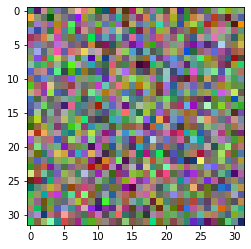

Starting model inversion
Teacher correct out of 200: 21, loss at 5.037278652191162
Student correct out of 200: 21, loss at 2.4372386932373047


It 0	 Losses: total: 38.427,	target: 5.056 	R_feature_loss unscaled:	 4.002
It 200	 Losses: total: 10.455,	target: 0.001 	R_feature_loss unscaled:	 0.409
It 400	 Losses: total: 9.729,	target: 0.001 	R_feature_loss unscaled:	 0.302
It 600	 Losses: total: 9.470,	target: 0.000 	R_feature_loss unscaled:	 0.300
It 800	 Losses: total: 9.227,	target: 0.001 	R_feature_loss unscaled:	 0.238
It 1000	 Losses: total: 9.184,	target: 0.001 	R_feature_loss unscaled:	 0.240
It 1200	 Losses: total: 9.081,	target: 0.000 	R_feature_loss unscaled:	 0.253
It 1400	 Losses: total: 9.228,	target: 0.000 	R_feature_loss unscaled:	 0.275

Teacher correct out of 200: 200, loss at 0.00042748849955387414
Student correct out of 200: 1, loss at 2.747554302215576


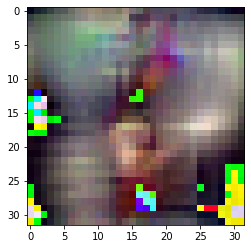

deepinversion finshed


In [87]:
'''
!git clone https://github.com/NVlabs/DeepInversion.git

!pip install tensorboardX
! cp -r /content/DeepInversion/cifar10/deepinversion_cifar10.py /content
! cp -r /content/DeepInversion/cifar10/resnet_cifar.py /content
'''
#from resnet_cifar import ResNet18 # HO IMPORTATO LA CLASSE DEL PAPER E PROVATO CON LA LORO RESNET 18 (non cambia nulla)
labels_of_modified = torch.zeros(0, dtype = int).to('cuda')
for label in batch:
  labels = torch.LongTensor([diz[label]]*20).to('cuda')
  labels_of_modified = torch.cat((labels_of_modified, labels), dim=0)
print('len to be created', len(labels_of_modified))
number_of_images_created = 200

teacher = copy.deepcopy(model)
net_teacher = resnet32(num_classes=10).to('cuda')
net_teacher.load_state_dict(teacher.state_dict())
#net_student = resnet32(num_classes=10).to('cuda')
#net_student = ResNet18().to('cuda')
net_student = resnet18().to('cuda')
net_teacher.eval()
trials.eval()

inputs = torch.randn((number_of_images_created, 3, 32, 32), requires_grad=True, device='cuda', dtype=torch.float)
train_writer = None  # tensorboard writter
global_iteration = 0
di_lr = 0.05
optimizer_di = optim.Adam([inputs], lr=di_lr)
plt.imshow(tensor2im(inputs[0]))
plt.show()
print("Starting model inversion")
batch_idx = 0
inputs = get_images(net=trials, bs=len(labels_of_modified), epochs=1500, idx=batch_idx, 
                  net_student=net_student, competitive_scale=10.0, l2_coeff = 3e-8, bn_reg_scale = 5.0,
                  train_writer=train_writer, use_amp=False,
                  optimizer=optimizer_di, inputs=inputs, 
                  var_scale=0.001, labels=labels_of_modified) #2.5e-5

plt.imshow(tensor2im(inputs[0]))
plt.show()
print('deepinversion finshed')

In [ ]:
fake_diz = {0:11, 1:5, 2:62, 3:76, 4:27, 5:3, 6:96, 7:33, 8:78, 9:30}

In [143]:
exemplar_dataset = ilCIFAR100(10, 203, train = 'exemplar')
for i in range(len(labels_of_modified)):
  exemplar_dataset.dataset.data[i] = tensor2im(inputs[i])
  exemplar_dataset.dataset.targets[i] = fake_diz[labels_of_modified[i].item()]
  
exemplar_dataset = Subset(exemplar_dataset, np.arange(200))


Files already downloaded and verified


In [ ]:
final_trainloader = DataLoader(torch.utils.data.ConcatDataset([train_dataset, exemplar_dataset]), batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
fake_model = resnet32(num_classes=10).to(self.device)

optimizer = optim.SGD(fake_model.parameters(), lr=2, momentum=0.9, weight_decay= 1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[49,63], gamma=0.2)
criterion = nn.BCEWithLogitsLoss()

for epoch in tqdm(range(70)):
    
  for _, inputs, labels in final_trainloader:
    inputs = inputs.float().to('cuda')
    labels = torch.tensor([diz[c.item()] for c in labels])

    labels=labels.to('cuda')
    optimizer.zero_grad()
    outputs=model(inputs)

    labels_encoded = F.one_hot(labels,10).float().to('cuda') #CAMBIARE ONE_HOT
    loss = criterion(outputs, labels_encoded) 

    loss.backward()
    optimizer.step()
  
  scheduler.step()

total = 0.0
correct = 0.0
for  _, images, labels in test_loader:
  labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
  labels = labels.to('cuda')
  images = images.to('cuda')
  outputs = model(images)
  _, preds = torch.max(outputs, dim=1)
  total += len(labels)
  correct += torch.sum(preds == labels).item()

acc = correct / total
print('test accuracy with syntetic exemplars', acc)